# Overview

* [Live Signals](#livesignals)
* [Raw Packets](#rawpackets)



## Live Signals

In [1]:
import asyncio
import neaspec
import configuration as config

context = await neaspec.connect(config.db, config.vm, config.dll)

> Redirecting unknown loading assembly System.Runtime.CompilerServices.Unsafe, Version=4.0.4.1, Culture=neutral, PublicKeyToken=b03f5f7f11d50a3a
> Configuration in local file C:\Users\Patrick\AppData\Local\Python_Software_Foundatio\DefaultDomain_Path_mndturxegrmy5qhqcgfnwau3k5cajhfi\3.7.9\user.config
> Loaded from database group: Nea.Client.Hardware.Microscope.Properties.Settings
> Loaded from database group: Nea.Client.Hardware.Camera.Properties.Settings
> No camera found. Discovery result: Success
> Waiting for initialization...
> Trying to connect to 127.0.0.1
> Trying to connect to 127.0.0.1
> Trying to connect to 127.0.0.1
> Connected to 127.0.0.1
> Connected to 127.0.0.1
> Connected to 127.0.0.1
> Receive thread (Nea.Client.Hardware.Rpc) started.
> Receive thread (Nea.Client.Hardware.MotorRpc) started.
> Receive thread (Nea.Client.Hardware.PreviewRpc) started.
> Client 1.10.7701 is incompatible with Server 1.10.7702.
> Server Fingerprint: [00313679-3dbe-4d4a-9105-16835504fc97] ha

When subscribing for receiving notifications e.g. `Microscope.DataDemodulated` it is very important to unsubscribe. Therefore we can wrap the grabbing of signals in a class with Enter/Exit functions.

In [2]:
import matplotlib.pyplot as plt
import numpy

import Nea.Client.SharedDefinitions as shared

class Capture:
	def __init__(self, figure, ax):
		self.y_data = []
		self.figure = figure
		self.ax = ax
        
	def onDataDemodulated(self, o, e):
		# print(f'DC: {e.Mechanical[0]} M1A: {e.Mechanical[2]} M1P: {e.Mechanical[3]}')
		self.y_data.append(e.Mechanical[2])
		self.ax.plot(self.y_data, 'r')
        
		self.figure.canvas.draw()
        
	def __enter__ (self):            
		# Subscribe to events
		context.Microscope.DataDemodulated += self.onDataDemodulated
		return self
	
	def __exit__(self, exception_type, exception_value, traceback):
		# Unsubscribe from events
		context.Microscope.DataDemodulated -= self.onDataDemodulated


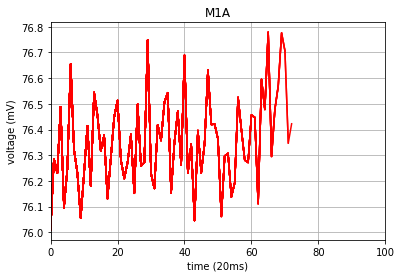

In [3]:
# %matplotlib notebook

import matplotlib.pyplot as plt

from time import sleep

figure = plt.figure()
ax = figure.add_subplot()
ax.set_xlim(0,100)

ax.set(xlabel='time (20ms)', ylabel='voltage (mV)', title='M1A')
ax.grid()


# capture will start immediately and run in the background
with Capture(figure, ax) as capture:
    # wait a few seconds
    sleep(3)


# Raw packet

for demonstration only the first 100 data points are shown


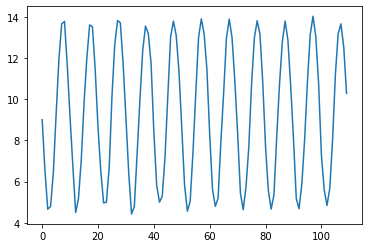

In [4]:
context.Microscope.IsAnalogDumpEnabled = True

import Nea.Client.SharedDefinitions as nea

buffer = []

while True:
    data = context.Microscope.GetDumpedAnalogIn(nea.Signal.Mechanical, len(buffer), len(buffer) + 10).Result
    if len(data) == 0:
        print("no more data")
        break
        
    if len(buffer) > 100:
        print("for demonstration only the first 100 data points are shown")
        break
        
    for d in data:
        buffer.append(d)

context.Microscope.IsAnalogDumpEnabled = False

import matplotlib.pyplot as plt
plt.plot(buffer)
